In [25]:
using Revise
using Bilevel

using RigidBodyDynamics
using MeshCatMechanisms
using MeshCat
using ForwardDiff
using Plots
using LinearAlgebra
using StaticArrays
using Base.Threads

In [36]:
nthreads()

16

In [37]:
urdf = joinpath("..", "urdf", "ball.urdf")
mechanism = parse_urdf(Float64, urdf)

floor = findbody(mechanism, "floor")
point = Point3D(default_frame(floor), SVector([0.,0.,0.]...))
normal = FreeVector3D(default_frame(floor), SVector([0.,0.,1.]...))
floor_obs = Obstacle(floor, point, normal, :xyz, .5)

obstacles = [floor_obs]
env = Environment(mechanism, urdf, obstacles)
ctrl! = (u,t,x) -> u[:] .= 0.
x0 = MechanismState(mechanism)
Δt = .01

0.01

In [48]:
q1 = [1., 0., 0., 0., 0., 0., 0.]
qN = [1., 0., 0., 0., .1, 0., 0.]
N = 10
Δt = .01

0.01

In [49]:
sim_data_indirect = get_trajopt_data_indirect(mechanism,env,Δt,N,relax_comp=false)

# adding user defined constraint
vs = sim_data_indirect.vs

add_eq!(sim_data_indirect, :cq1, length(q1), x -> vs(x, :q1) - q1)
add_eq!(sim_data_indirect, :cqN, length(qN), x -> vs(x, Symbol("q", N)) - qN)

add_box_con!(sim_data_indirect, :u, :u, zeros(num_velocities(mechanism)), zeros(num_velocities(mechanism)), 1:N-1)
add_box_con!(sim_data_indirect, :hbox, :h, [.005], [.01], 1:N-1)

for i=1:N
    add_ineq!(sim_data_indirect, Symbol("height",i), 1, x -> vs(x, Symbol("q",i))[7] - .001)
end

for i=1:N-1
    add_obj!(sim_data_indirect, Symbol("v",i), x -> vs(x, Symbol("h",i))[1]*vs(x, Symbol("v",i))'*vs(x, Symbol("v",i)))
end
add_obj!(sim_data_indirect, Symbol("v",N), x -> vs(x, Symbol("v",N))'*vs(x, Symbol("v",N)))

10-element Array{Tuple{Symbol,Any},1}:
 (:v1, getfield(Main, Symbol("##139#140")){Int64}(1))
 (:v2, getfield(Main, Symbol("##139#140")){Int64}(2))
 (:v3, getfield(Main, Symbol("##139#140")){Int64}(3))
 (:v4, getfield(Main, Symbol("##139#140")){Int64}(4))
 (:v5, getfield(Main, Symbol("##139#140")){Int64}(5))
 (:v6, getfield(Main, Symbol("##139#140")){Int64}(6))
 (:v7, getfield(Main, Symbol("##139#140")){Int64}(7))
 (:v8, getfield(Main, Symbol("##139#140")){Int64}(8))
 (:v9, getfield(Main, Symbol("##139#140")){Int64}(9))
 (:v10, getfield(Main, Symbol("##141#142"))())       

In [50]:
traj_indirect = Bilevel.trajopt(sim_data_indirect, quaternion_state=true, verbose=1)

Finished successfully: optimality conditions satisfied


(Array{Float64,1}[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 5.06336e-12, -4.55018e-5, 6.80215e-13, 0.0125784, -1.44622e-14, 0.0009905], [1.0, 2.4872e-12, -9.14452e-5, 6.96916e-13, 0.0251566, -1.03396e-15, 0.001], [1.0, 2.47308e-12, -0.000234415, 6.93925e-13, 0.0377346, -7.76916e-15, 2.85001e-5], [1.0, 2.3972e-12, -0.000152481, -1.79747e-14, 0.0493503, -2.48435e-15, 3.71554e-22], [1.0, 6.47497e-17, -7.06055e-5, 2.91398e-14, 0.0604613, -1.18225e-16, 0.0], [1.0, -9.54564e-18, -5.99726e-5, 2.10705e-14, 0.0710817, -7.84851e-17, -5.50763e-14], [1.0, -8.38247e-17, -3.6679e-5, 1.47651e-14, 0.0812117, -4.49554e-17, -6.77626e-21], [1.0, -4.19125e-17, -4.20901e-7, 1.46377e-14, 0.0908511, -1.93365e-17, 8.4159e-14], [1.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0]], Array{Float64,1}[[2.22367e-10, -0.00910293, 5.18789e-12, 1.25784, 7.78507e-13, 0.19715], [1.02251e-9, -0.00910036, 1.44521e-10, 1.25784, -1.01902e-12, 0.0989355], [-5.64829e-10, -0.00918868, 8.17006e-15, 1.25783, -1.48782e-12, 0.000719954], [-4.330

In [77]:
sim_data_semidirect = get_trajopt_data_semidirect(mechanism,env,Δt,N,relax_comp=false)

# adding user defined constraint
vs = sim_data_semidirect.vs

add_eq!(sim_data_semidirect, :cq1, length(q1), x -> vs(x, :q1) - q1)
add_eq!(sim_data_semidirect, :cqN, length(qN), x -> vs(x, Symbol("q", N)) - qN)

add_box_con!(sim_data_semidirect, :u, :u, zeros(num_velocities(mechanism)), zeros(num_velocities(mechanism)), 1:N-1)
add_box_con!(sim_data_semidirect, :hbox, :h, [.005], [.01], 1:N-1)

for i=1:N
    add_ineq!(sim_data_semidirect, Symbol("height",i), 1, x -> vs(x, Symbol("q",i))[7] - .001)
end

for i=1:N-1
    add_obj!(sim_data_semidirect, Symbol("v",i), x -> vs(x, Symbol("h",i))[1]*vs(x, Symbol("v",i))'*vs(x, Symbol("v",i)))
end
add_obj!(sim_data_semidirect, Symbol("v",N), x -> vs(x, Symbol("v",N))'*vs(x, Symbol("v",N)));

In [78]:
traj_semidirect = Bilevel.trajopt(sim_data_semidirect, quaternion_state=true, verbose=1)

Finished successfully: optimality conditions satisfied


(Any[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, -1.78352e-7, 8.92195e-6, 6.62872e-11, 0.0128278, 2.75727e-11, 0.0004905], [1.0, -1.56904e-7, 1.42026e-5, 4.3909e-11, 0.0256557, 1.31817e-11, 0.0], [1.0, -1.65605e-7, 1.73439e-5, 2.40038e-11, 0.0375026, 1.57691e-11, 0.0004905], [1.0, -2.05051e-7, 1.81406e-5, 9.74197e-12, 0.0493495, 9.56701e-11, 0.0], [1.0, -2.05051e-7, 1.66555e-5, -5.74595e-12, 0.0604606, 1.75531e-10, 0.0], [1.0, -2.4549e-7, 1.66555e-5, 7.03654e-12, 0.0710812, 3.34633e-10, 0.0], [1.0, -2.11988e-7, 1.05212e-5, 3.36666e-12, 0.0807208, 4.28003e-10, 0.000981], [1.0, -1.11768e-7, 1.99609e-6, 0.0, 0.0903604, 3.23711e-10, 0.000981], [1.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0]], Any[[0.0, 0.0, 0.0, 1.28278, -3.22735e-8, 0.14715], [-3.56703e-5, 0.00178439, 1.32574e-8, 1.28278, -1.4858e-8, 0.0490729], [4.28957e-6, 0.00105613, 0.0, 1.28279, 1.38342e-8, -0.0490136], [-1.74027e-6, 0.000628262, 0.0, 1.18469, -1.61054e-8, 0.0490911], [-7.88913e-6, 0.000159336, 0.0, 1.18469, 2.79461e-8, -0.049007

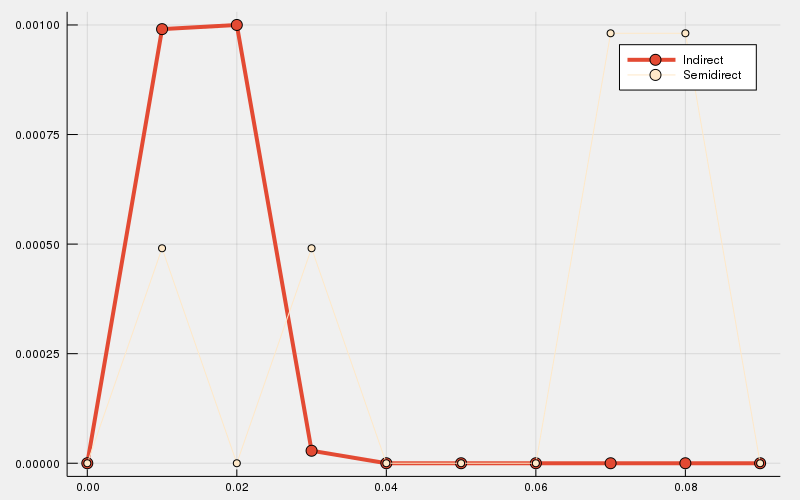

In [81]:
j = 7
clibrary(:Plots)
gr(size=(800,500), html_output_format=:png, 
    seriescolor=:magma,  background_color_legend=:white, 
    background=RGB(((240,240,240) ./ 255.)...));
plot(traj_indirect[7],traj_indirect[8][j,:],label="Indirect",seriescolor=RGB(((227,74,51) ./ 255.)...),linewidth=4,marker=6)
# plot!(traj_direct[7],traj_direct[8][j,:],label="Direct",seriescolor=RGB(((254,232,200) ./ 255.)...),linewidth=0,marker=4)
plot!(traj_semidirect[7],traj_semidirect[8][j,:],label="Semidirect",seriescolor=RGB(((254,232,200) ./ 255.)...),linewidth=0,marker=4)

In [6]:
q1 = [1., 0., 0., 0., 0., 0., 0.017]
v1 = [0., 0., 0., 1., 0., 0.]
N = 25

25

In [ ]:
sim_data_direct = get_trajopt_data_direct(mechanism,env,Δt,N,relax_comp=false)

# adding user defined constraint
vs = sim_data_direct.vs

add_eq!(sim_data_direct, :cq1, length(q1), x -> vs(x, :q1) - q1)
add_eq!(sim_data_direct, :cqN, length(qN), x -> vs(x, Symbol("q", N)) - qN)

add_box_con!(sim_data_direct, :u, :u, zeros(num_velocities(mechanism)), zeros(num_velocities(mechanism)), 1:N-1)
add_box_con!(sim_data_direct, :hbox, :h, [.005], [.01], 1:N-1)

for i=1:N
    add_ineq!(sim_data_direct, Symbol("height",i), 1, x -> vs(x, Symbol("q",i))[7] - .001)
end

# for i=1:N-1
#     add_obj!(sim_data_direct, Symbol("v",i), x -> vs(x, Symbol("h",i))[1]*vs(x, Symbol("v",i))'*vs(x, Symbol("v",i)))
# end
# add_obj!(sim_data_direct, Symbol("v",N), x -> vs(x, Symbol("v",N))'*vs(x, Symbol("v",N)));

In [ ]:
sim_data_indirect = get_sim_data_indirect(mechanism,env,Δt,relax_comp=false)
set_configuration!(x0, q1)
set_velocity!(x0, v1)
traj_indirect = Bilevel.simulate(sim_data_indirect, ctrl!, x0, N, verbose=1)

In [ ]:
sim_data_direct = get_sim_data_direct(mechanism,env,Δt,relax_comp=false)
set_configuration!(x0, q1)
set_velocity!(x0, v1)
traj_direct = Bilevel.simulate(sim_data_direct, ctrl!, x0, N, verbose=1)

In [ ]:
j = 7
clibrary(:Plots)
gr(size=(800,500), html_output_format=:png, 
    seriescolor=:magma,  background_color_legend=:white, 
    background=RGB(((240,240,240) ./ 255.)...));
plot(traj_indirect[6],traj_indirect[7][j,:],label="Indirect",seriescolor=RGB(((227,74,51) ./ 255.)...),linewidth=4,marker=6)
plot!(traj_direct[6],traj_direct[7][j,:],label="Direct",seriescolor=RGB(((254,232,200) ./ 255.)...),linewidth=0,marker=4)

In [ ]:
traj_direct = Bilevel.trajopt(sim_data_direct, quaternion_state=true, verbose=1)